--- Starting Cancer Diagnosis Prediction Project ---
Data loaded successfully from cancer.csv

--- Initial Data Overview ---
First 5 rows:
          id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   


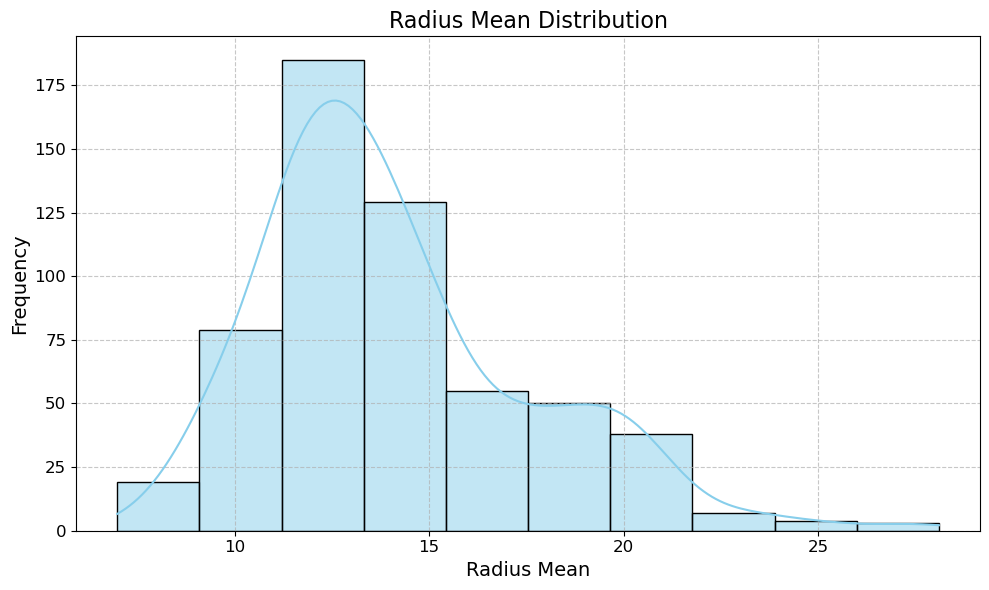

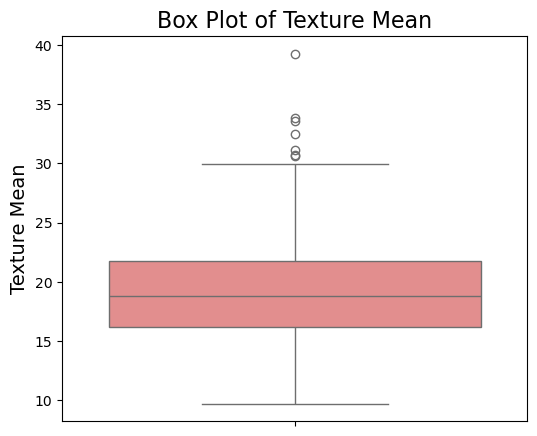

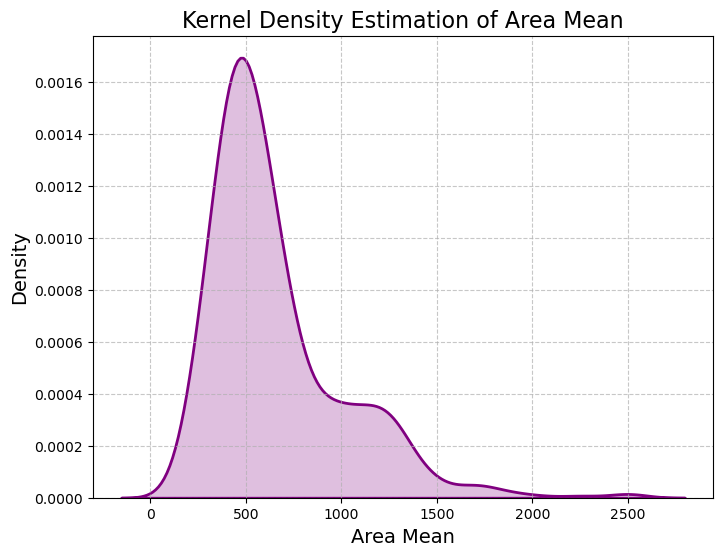

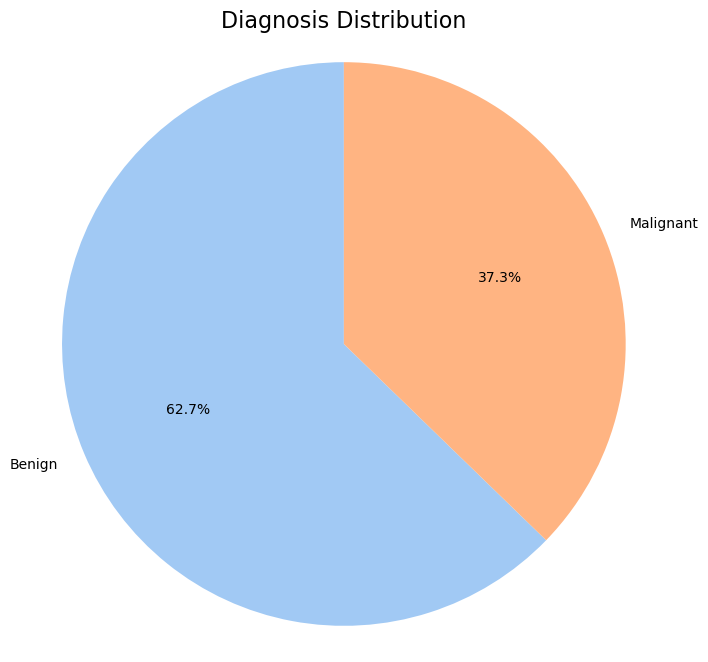


--- Bivariate Analysis Plots ---


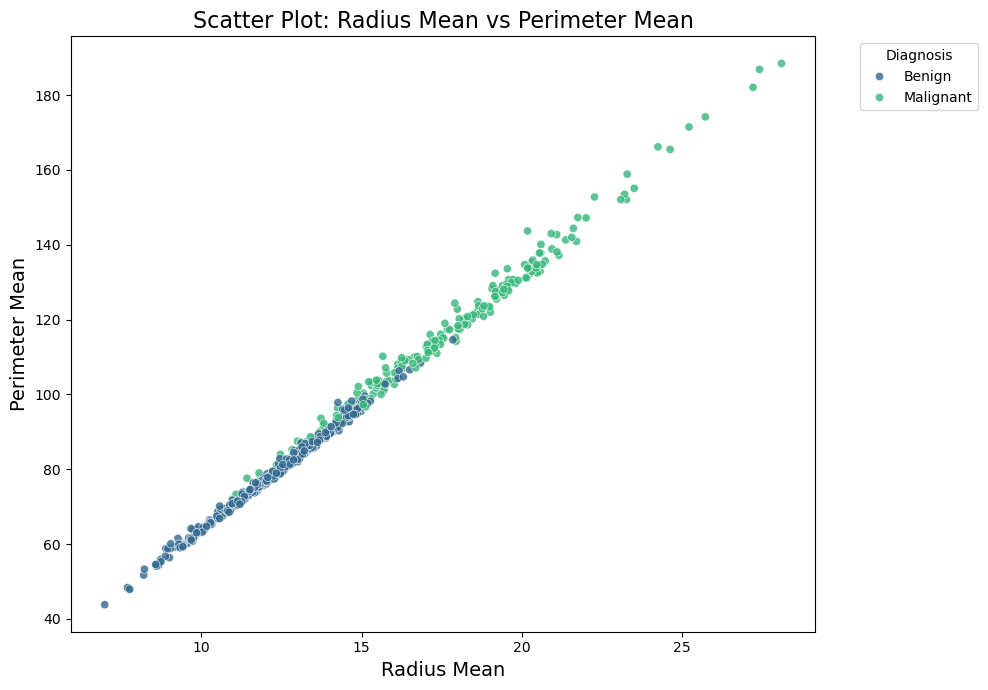

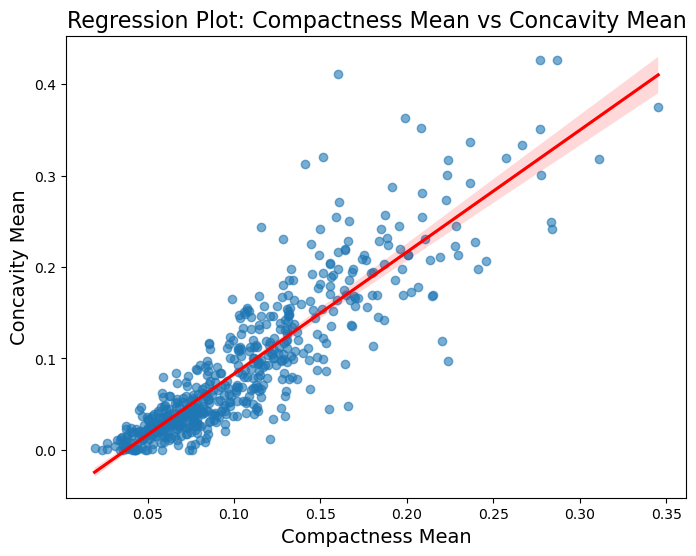

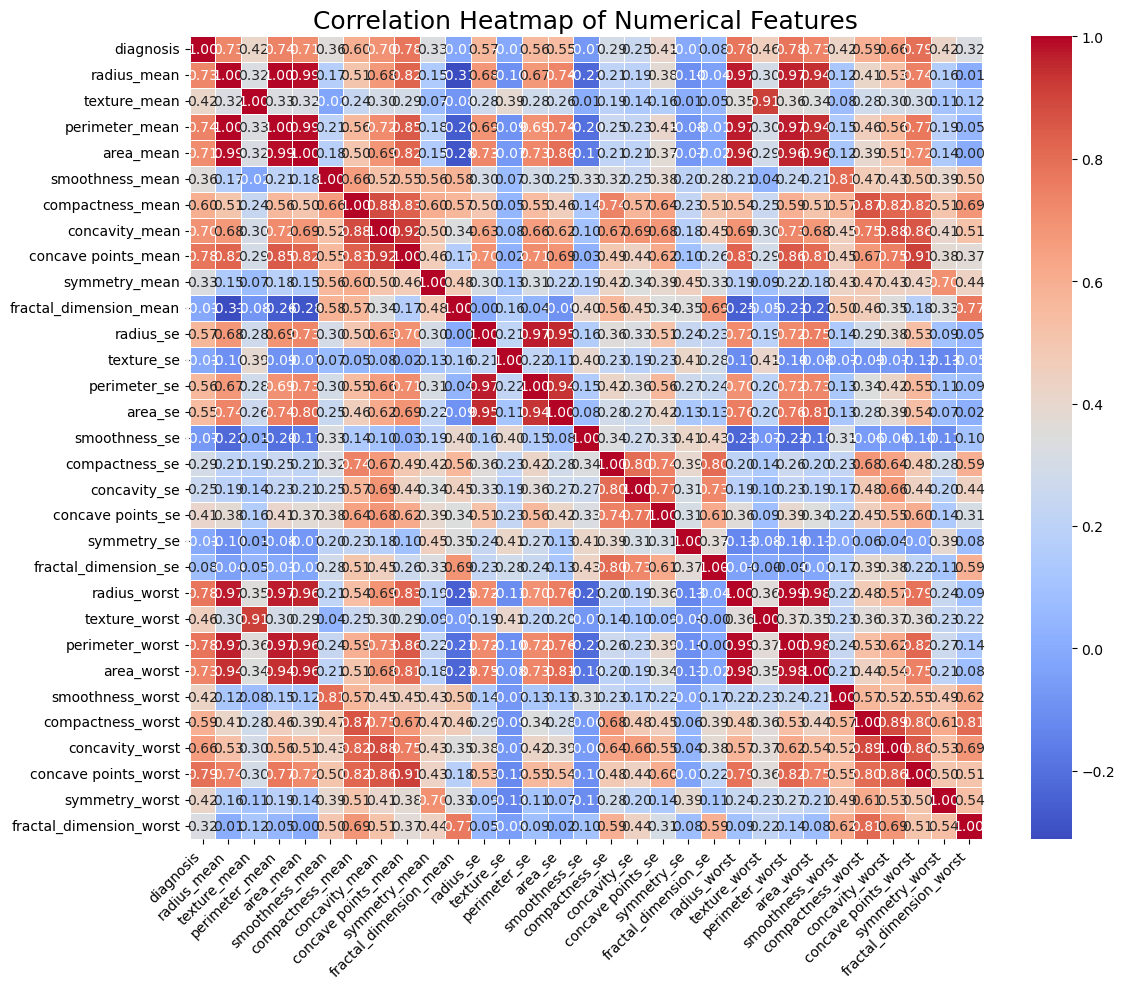

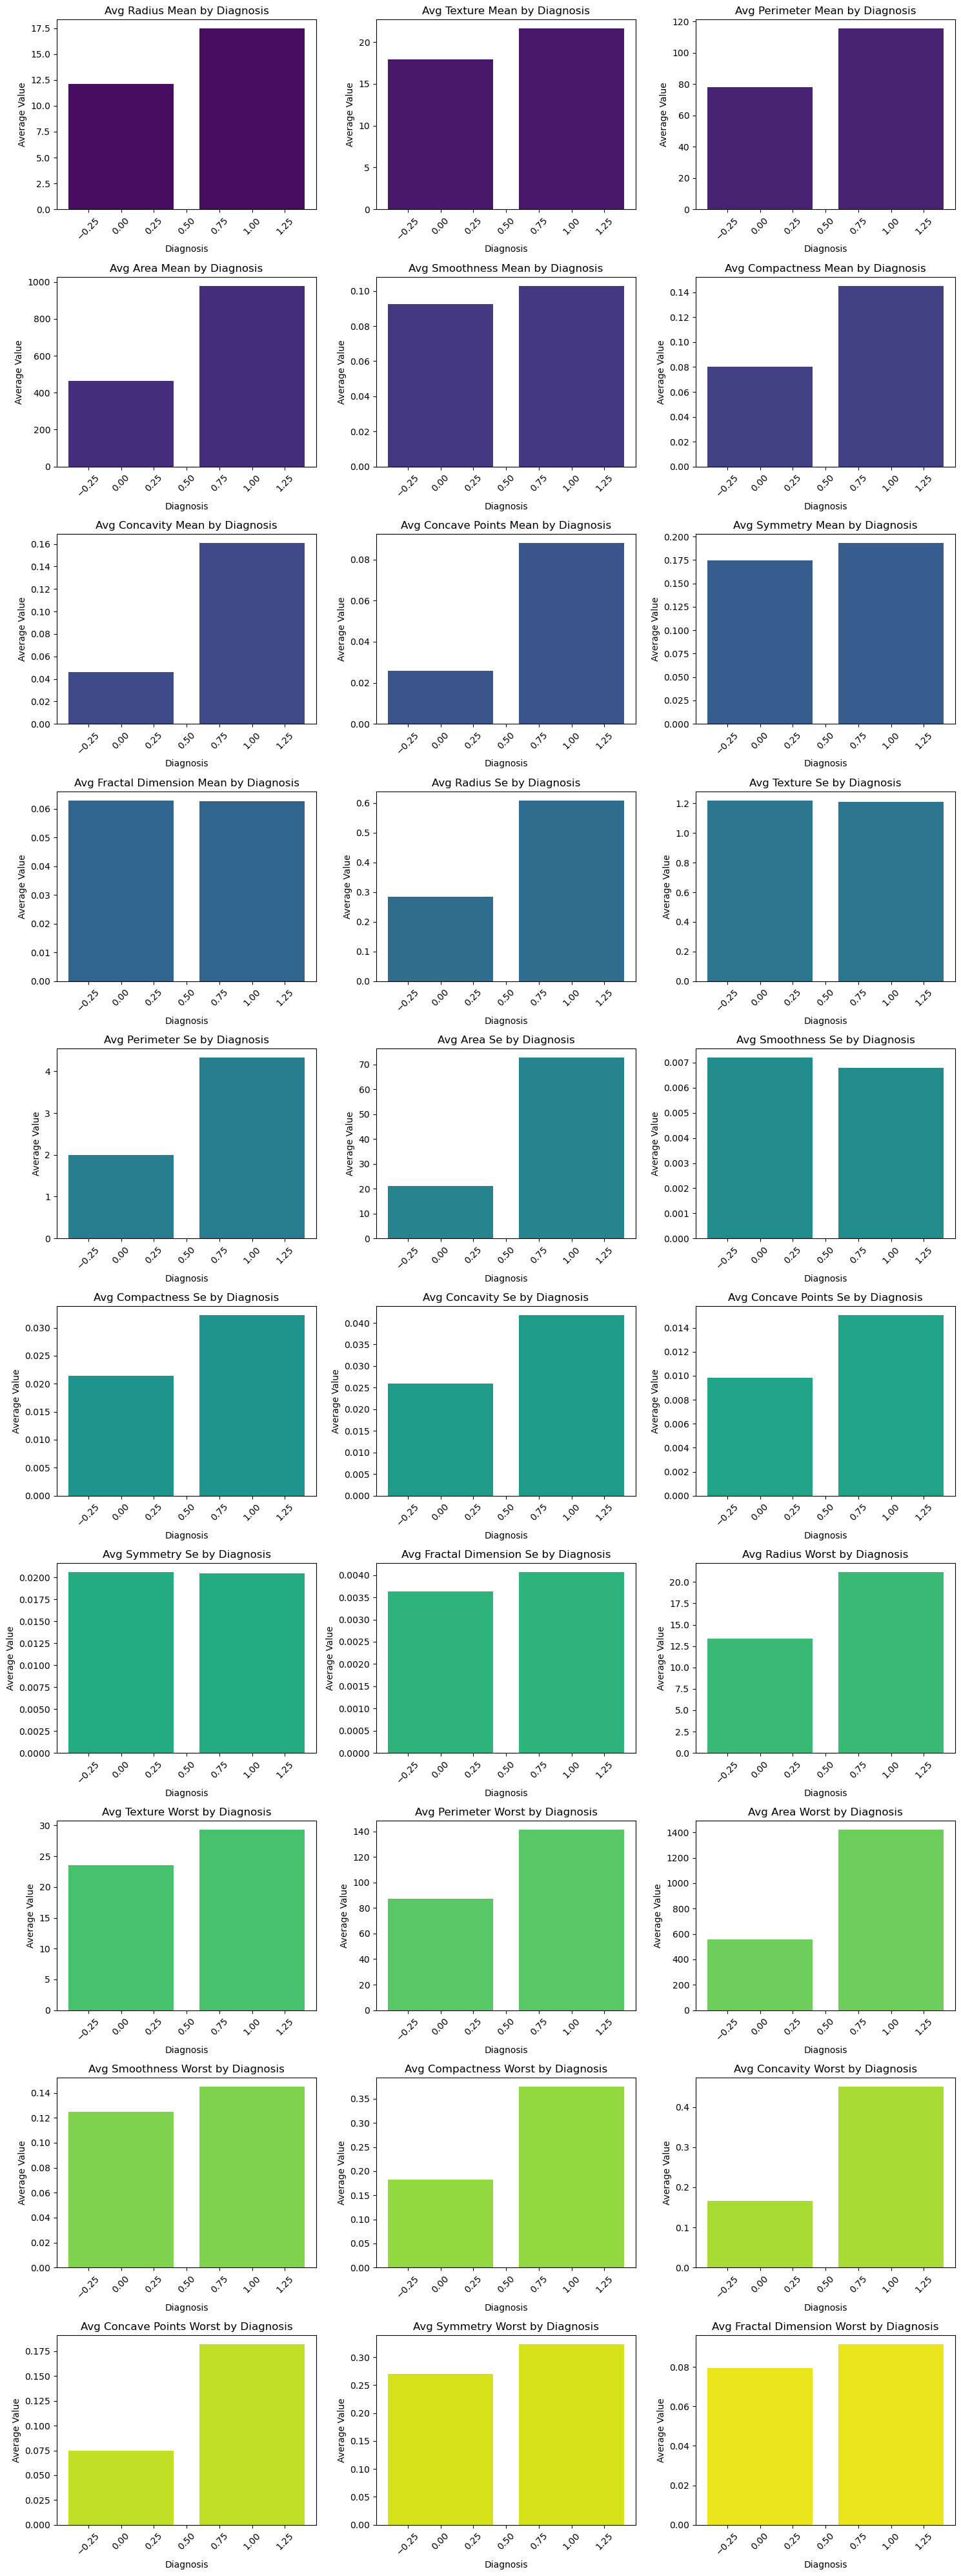

Splitting data with test_size=0.2, random_state=42
Data split: X_train:(455, 30), X_test:(114, 30), y_train:(455,), y_test:(114,)

--- Scaling Features ---
Features scaled.
ModelTrainer initialized with SVC (kernel='linear')
Training model...
Model training complete.

--- Model Evaluation ---
Model Accuracy: 0.9649

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

Model saved to svm_cancer_diagnosis_model.pkl

--- Testing Model Loading ---
Model loaded from svm_cancer_diagnosis_model.pkl
Sample predictions from loaded_model: [0 1 0 0 0]
Actual values for sample: [0, 1, 0, 1, 0]

--- Project Execution Finished ---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pickle
import os

# Cancer Diagnosis Prediction

# Import necessary libraries
class DataLoader:
    """
    Handles loading and providing basic information about the dataset.
    """
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = None

    def load_data(self):
        """Loads the dataset from the specified filepath."""
        if not os.path.exists(self.filepath):
            print(f"Error: File not found at {self.filepath}")
            return None
        try:
            self.data = pd.read_csv(self.filepath)
            print(f"Data loaded successfully from {self.filepath}")
            return self.data
        except Exception as e:
            print(f"Error loading data: {e}")
            return None

    def show_info(self):
        """Prints a concise summary of the DataFrame."""
        if self.data is not None:
            print("\n--- Data Info ---")
            self.data.info()
        else:
            print("No data loaded.")

# Data Preprocessing

class DataPreprocessor:
    """
    Performs essential data preprocessing steps on the DataFrame for cancer.csv.
    """
    def __init__(self, data):
        self.data = data.copy()

    def preprocess(self):
        """
        Performs a sequence of preprocessing steps for the cancer dataset:
        1. Drops irrelevant columns ('id', 'Unnamed: 32').
        2. Cleans missing values from remaining columns.
        3. Encodes the 'diagnosis' column to numerical format.
        Returns:
            pd.DataFrame: The processed DataFrame.
        """
        print(f"Shape before preprocessing: {self.data.shape}")

        # 1. Drop irrelevant columns: 'id' (identifier) and 'Unnamed: 32' (often empty/redundant)
        columns_to_drop = ['id', 'Unnamed: 32']
        existing_columns_to_drop = [col for col in columns_to_drop if col in self.data.columns]
        if existing_columns_to_drop:
            self.data.drop(columns=existing_columns_to_drop, inplace=True)
            print(f"Dropped columns: {', '.join(existing_columns_to_drop)}. New shape: {self.data.shape}")
        else:
            print("No irrelevant columns found to drop.")

        # 2. Clean missing values (if any) from the *remaining* columns
        initial_rows_after_drop = len(self.data)
        self.data.dropna(inplace=True)
        dropped_rows_count = initial_rows_after_drop - len(self.data)
        if dropped_rows_count > 0:
            print(f"Cleaned data: Dropped {dropped_rows_count} rows with missing values after column drop. New shape: {self.data.shape}")
        else:
            print("No missing values found in remaining columns, no rows dropped by dropna.")

        if self.data.empty:
            print("Error: DataFrame became empty after dropping columns and/or missing values. Cannot proceed with further preprocessing.")
            return self.data # Return empty DataFrame, subsequent steps should handle this

        # 3. Encode 'diagnosis' column (M=Malignant, B=Benign) to numerical (e.g., 0/1)
        if 'diagnosis' in self.data.columns and self.data['diagnosis'].dtype == 'object':
            le = LabelEncoder()
            self.data['diagnosis'] = le.fit_transform(self.data['diagnosis'])
            print("Encoded 'diagnosis' column (Malignant/Benign to numerical).")
        else:
            print("Diagnosis column not found or already numerical.")

        return self.data

# Graph

class Graph:
    """
    Provides methods for generating various types of plots for data visualization.
    """
    def __init__(self, df):
        self.df = df

    def plot_histogram(self, column, bins=10, title_suffix="Distribution"):
        """
        Plots a histogram for a specified numerical column.
        Args:
            column (str): The name of the column to plot.
            bins (int): Number of bins for the histogram.
            title_suffix (str): Suffix for the plot title.
        """
        if column not in self.df.columns:
            print(f"Error: Column '{column}' not found in DataFrame.")
            return

        plt.figure(figsize=(10, 6))
        sns.histplot(self.df[column], bins=bins, kde=True, color='skyblue', edgecolor='black')
        plt.title(f'{column.replace("_", " ").title()} {title_suffix}', fontsize=16)
        plt.xlabel(column.replace("_", " ").title(), fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_bar(self, group_col, value_cols=None):
        """
        Plots bar charts for average values by a grouping column.
        Args:
            group_col (str): The column to group by (e.g., 'quality' or 'diagnosis').
            value_cols (list): List of numerical columns to plot averages for.
        """
        if value_cols is None:
            # Default to all numerical columns except the grouping column
            value_cols = self.df.select_dtypes(include=np.number).columns.drop(group_col, errors='ignore').tolist()
            # Exclude 'id' and 'Unnamed: 32' if they somehow persist or are not dropped earlier
            value_cols = [col for col in value_cols if col not in ['id', 'Unnamed: 32']]


        if group_col not in self.df.columns:
            print(f"Error: Grouping column '{group_col}' not found.")
            return
        if not all(col in self.df.columns for col in value_cols):
            print("Error: One or more value columns not found.")
            return

        avg_values = self.df.groupby(group_col)[value_cols].mean()
        
        num_plots = len(value_cols)
        num_cols = 3
        num_rows = (num_plots + num_cols - 1) // num_cols

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
        axes = axes.flatten()

        colors = sns.color_palette("viridis", num_plots)

        for i, value_col in enumerate(value_cols):
            if i < len(axes): # Ensure we don't go out of bounds if num_plots is less than num_cols * num_rows
                axes[i].bar(avg_values.index, avg_values[value_col], color=colors[i])
                axes[i].set_title(f'Avg {value_col.replace("_", " ").title()} by {group_col.replace("_", " ").title()}', fontsize=12)
                axes[i].set_ylabel('Average Value', fontsize=10)
                axes[i].set_xlabel(group_col.replace("_", " ").title(), fontsize=10)
                axes[i].tick_params(axis='x', rotation=45)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    def plot_pie(self, column):
        """
        Plots a pie chart for the distribution of a categorical or discrete numerical column.
        Args:
            column (str): The name of the column to plot.
        """
        if column not in self.df.columns:
            print(f"Error: Column '{column}' not found in DataFrame.")
            return
        
        counts = self.df[column].value_counts()

        if len(counts) > 15:
            print(f"Warning: Column '{column}' has too many unique values ({len(counts)}) for a readable pie chart. Consider a bar chart instead.")
            self.plot_bar(column, value_cols=[])
            return

        plt.figure(figsize=(8, 8))
        plt.pie(
            counts,
            labels=counts.index.map(lambda x: 'Malignant' if x == 1 else ('Benign' if x == 0 else x)), # Map diagnosis back for labels
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('pastel')
        )
        plt.title(f'{column.replace("_", " ").title()} Distribution', fontsize=16)
        plt.axis('equal')
        plt.show()

    def plot_box(self, x_col, y_col):
        """
        Plots a box plot to show distribution of a numerical column across categories.
        Args:
            x_col (str): Categorical or discrete numerical column for x-axis.
            y_col (str): Numerical column for y-axis.
        """
        if x_col not in self.df.columns or y_col not in self.df.columns:
            print(f"Error: One or both columns ('{x_col}', '{y_col}') not found in DataFrame.")
            return

        plt.figure(figsize=(8, 6))
        sns.boxplot(x=self.df[x_col], y=self.df[y_col], palette='coolwarm')
        plt.title(f'{y_col.replace("_", " ").title()} Distribution by {x_col.replace("_", " ").title()}', fontsize=16)
        plt.xlabel(x_col.replace("_", " ").title(), fontsize=14)
        plt.ylabel(y_col.replace("_", " ").title(), fontsize=14)
        plt.show()

    def plot_scatter(self, x_col, y_col, hue=None):
        """
        Plots a scatter plot to show relationship between two numerical columns, with optional hue.
        Args:
            x_col (str): Numerical column for x-axis.
            y_col (str): Numerical column for y-axis.
            hue (str, optional): Categorical or discrete numerical column for coloring points.
        """
        if x_col not in self.df.columns or y_col not in self.df.columns:
            print(f"Error: One or both columns ('{x_col}', '{y_col}') not found in DataFrame.")
            return
        if hue and hue not in self.df.columns:
            print(f"Warning: Hue column '{hue}' not found. Plotting without hue.")
            hue = None

        plt.figure(figsize=(10, 7))
        sns.scatterplot(x=self.df[x_col], y=self.df[y_col], hue=self.df[hue] if hue else None, palette='viridis', alpha=0.8)
        plt.title(f'Scatter Plot: {x_col.replace("_", " ").title()} vs {y_col.replace("_", " ").title()}', fontsize=16)
        plt.xlabel(x_col.replace("_", " ").title(), fontsize=14)
        plt.ylabel(y_col.replace("_", " ").title(), fontsize=14)
        if hue:
            # Map hue labels back for clarity if 'diagnosis' is used
            if hue == 'diagnosis':
                handles, labels = plt.gca().get_legend_handles_labels()
                new_labels = ['Malignant' if label == '1' else ('Benign' if label == '0' else label) for label in labels]
                plt.legend(handles=handles, labels=new_labels, title=hue.replace("_", " ").title(), bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                plt.legend(title=hue.replace("_", " ").title(), bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Univariate Analysis

class Univariate(Graph):
    """
    Extends Graph for specific univariate analysis plots.
    """
    def __init__(self, df):
        super().__init__(df)

    def plot_histogram(self, column, bins=10):
        super().plot_histogram(column, bins=bins, title_suffix="Distribution")

    def plot_box(self, column):
        """
        Plots a box plot for a single numerical column.
        Args:
            column (str): The numerical column to plot.
        """
        if column not in self.df.columns:
            print(f"Error: Column '{column}' not found in DataFrame.")
            return
        plt.figure(figsize=(6, 5))
        sns.boxplot(y=self.df[column], color='lightcoral')
        plt.title(f'Box Plot of {column.replace("_", " ").title()}', fontsize=16)
        plt.ylabel(column.replace("_", " ").title(), fontsize=14)
        plt.show()

    def plot_kde(self, column):
        """
        Plots a Kernel Density Estimate (KDE) plot for a numerical column.
        Args:
            column (str): The numerical column to plot.
        """
        if column not in self.df.columns:
            print(f"Error: Column '{column}' not found in DataFrame.")
            return
        plt.figure(figsize=(8, 6))
        sns.kdeplot(self.df[column], fill=True, color='purple', linewidth=2)
        plt.title(f'Kernel Density Estimation of {column.replace("_", " ").title()}', fontsize=16)
        plt.xlabel(column.replace("_", " ").title(), fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

# Bivariate Analysis

class Bivariate(Graph):
    """
    Extends Graph for specific bivariate analysis plots.
    """
    def __init__(self, df):
        super().__init__(df)

    def plot_scatter(self, x_col, y_col, hue=None):
        super().plot_scatter(x_col, y_col, hue=hue)

    def plot_regression(self, x_col, y_col):
        """
        Plots a regression plot to show the linear relationship between two numerical columns.
        Args:
            x_col (str): Numerical column for x-axis.
            y_col (str): Numerical column for y-axis.
        """
        if x_col not in self.df.columns or y_col not in self.df.columns:
            print(f"Error: One or both columns ('{x_col}', '{y_col}') not found in DataFrame.")
            return
        plt.figure(figsize=(8, 6))
        sns.regplot(x=self.df[x_col], y=self.df[y_col], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
        plt.title(f'Regression Plot: {x_col.replace("_", " ").title()} vs {y_col.replace("_", " ").title()}', fontsize=16)
        plt.xlabel(x_col.replace("_", " ").title(), fontsize=14)
        plt.ylabel(y_col.replace("_", " ").title(), fontsize=14)
        plt.show()

    def plot_heatmap(self):
        """
        Plots a correlation heatmap for numerical columns in the DataFrame.
        """
        numeric_df = self.df.select_dtypes(include=np.number)
        if numeric_df.empty:
            print("No numerical columns to plot heatmap for.")
            return

        plt.figure(figsize=(12, 10))
        sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
        plt.title("Correlation Heatmap of Numerical Features", fontsize=18)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()

# Data Splitting

class DataSplitter:
    """
    Splits the dataset into training and testing sets.
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def split(self, test_size=0.2, random_state=42):
        """Performs the train-test split."""
        print(f"Splitting data with test_size={test_size}, random_state={random_state}")
        # Stratify ensures that the proportion of target classes is maintained in train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=self.y
        )
        print(f"Data split: X_train:{X_train.shape}, X_test:{X_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")
        return X_train, X_test, y_train, y_test

# Model Training

class ModelTrainer:
    """
    Handles training and evaluating a Support Vector Classifier (SVC) model.
    """
    def __init__(self, kernel='linear'):
        self.model = SVC(kernel=kernel)
        print(f"ModelTrainer initialized with SVC (kernel='{kernel}')")

    def train(self, X_train, y_train):
        """Trains the SVC model."""
        print("Training model...")
        self.model.fit(X_train, y_train)
        print("Model training complete.")
        return self.model

    def evaluate(self, X_test, y_test):
        """Evaluates the trained model on the test set."""
        if self.model is None:
            print("Error: Model not trained yet.")
            return None
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model Accuracy: {accuracy:.4f}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        return accuracy

# Model Storage

class ModelStorage:
    """
    Provides static methods for saving and loading machine learning models.
    """
    @staticmethod
    def save_model(model, filename='svm_model.pkl'):
        """Saves a trained model to a file."""
        try:
            with open(filename, 'wb') as file:
                pickle.dump(model, file)
            print(f"Model saved to {filename}")
        except Exception as e:
            print(f"Error saving model: {e}")

    @staticmethod
    def load_model(filename='svm_model.pkl'):
        """Loads a trained model from a file."""
        if not os.path.exists(filename):
            print(f"Error: Model file not found at {filename}")
            return None
        try:
            with open(filename, 'rb') as file:
                model = pickle.load(file)
            print(f"Model loaded from {filename}")
            return model
        except Exception as e:
            print(f"Error loading model: {e}")
            return None

# Main Execution

if __name__ == "__main__":
    DATA_FILEPATH = 'cancer.csv' # Using the cancer.csv dataset
    MODEL_FILENAME = 'svm_cancer_diagnosis_model.pkl' # Renamed for clarity

    print("--- Starting Cancer Diagnosis Prediction Project ---")

    # 1. Data Collection
    loader = DataLoader(DATA_FILEPATH)
    df = loader.load_data()

    if df is not None:
        print("\n--- Initial Data Overview ---")
        print("First 5 rows:\n", df.head())
        loader.show_info()

        # 2. Data Preprocessing
        preprocessor = DataPreprocessor(df)
        df_processed = preprocessor.preprocess()

        # Added check if df_processed is empty after preprocessing
        if df_processed.empty:
            print("Error: Preprocessing resulted in an empty DataFrame. Cannot proceed with model building.")
            print("Please check your input data for excessive missing values or issues during column dropping.")
            print("Project execution halted.")
            exit() # Exit the script if DataFrame is empty

        # Define features (X) and target (y) for cancer dataset
        # 'diagnosis' is the target, all other numerical columns are features
        X = df_processed.drop(columns=['diagnosis'])
        y = df_processed['diagnosis']

        # Ensure all features are numeric for scaling and model input
        X = X.select_dtypes(include=np.number)

        # Added check if X is empty after selecting numeric dtypes
        if X.empty:
            print("Error: Features DataFrame (X) is empty after selecting numerical columns. "
                  "This might happen if all columns were dropped or not recognized as numerical. "
                  "Cannot proceed with model building.")
            print("Project execution halted.")
            exit() # Exit the script if X is empty

        print("\n--- Data after Preprocessing ---")
        print("Features (X) head:\n", X.head())
        print("Target (y) head:\n", y.head())
        print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

        # 3. Data Visualization (Univariate and Bivariate Analysis)
        print("\n--- Performing Univariate and Bivariate Data Visualization ---")

        univariate_analyzer = Univariate(df_processed)
        bivariate_analyzer = Bivariate(df_processed)

        # Univariate Analysis Examples for cancer.csv
        print("\n--- Univariate Analysis Plots ---")
        univariate_analyzer.plot_histogram('radius_mean')
        univariate_analyzer.plot_box('texture_mean')
        univariate_analyzer.plot_kde('area_mean')
        univariate_analyzer.plot_pie('diagnosis') # Distribution of diagnosis (Malignant/Benign)

        # Bivariate Analysis Examples for cancer.csv
        print("\n--- Bivariate Analysis Plots ---")
        bivariate_analyzer.plot_scatter('radius_mean', 'perimeter_mean', hue='diagnosis')
        bivariate_analyzer.plot_regression('compactness_mean', 'concavity_mean')
        bivariate_analyzer.plot_heatmap()
        bivariate_analyzer.plot_bar('diagnosis') # Average feature values by diagnosis

        # 4. Data Splitting
        splitter = DataSplitter(X, y)
        X_train, X_test, y_train, y_test = splitter.split()

        # 5. Feature Scaling (Important for SVM)
        print("\n--- Scaling Features ---")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        print("Features scaled.")

        # 6. Model Training
        trainer = ModelTrainer(kernel='linear')
        trained_model = trainer.train(X_train_scaled, y_train)

        # 7. Model Evaluation
        print("\n--- Model Evaluation ---")
        trainer.evaluate(X_test_scaled, y_test)

        # 8. Model Storage
        ModelStorage.save_model(trained_model, MODEL_FILENAME)

        # 9. (Optional) Load and test the model
        print("\n--- Testing Model Loading ---")
        loaded_model = ModelStorage.load_model(MODEL_FILENAME)
        if loaded_model:
            sample_prediction = loaded_model.predict(X_test_scaled[:5])
            print(f"Sample predictions from loaded_model: {sample_prediction}")
            print(f"Actual values for sample: {y_test.iloc[:5].tolist()}")

    else:
        print("Project execution halted due to data loading error.")

    print("\n--- Project Execution Finished ---")
